In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
def has_nans(x):
    return np.isnan(x).any()

def quick_stats(arr):
    return {
        "min": float(np.min(arr)),
        "max": float(np.max(arr)),
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
    }

def load_TxC(path):
    a = np.load(path)
    return a.T if a.shape[0] < a.shape[1] else a

def emg_envelope(emg, win=200):
    if emg.ndim == 1:
        emg = emg[:, None]
    kernel = np.ones(win) / win
    env = []
    for c in range(emg.shape[1]):
        env.append(np.sqrt(np.convolve(emg[:, c] ** 2, kernel, mode="same")))
    return np.stack(env, axis=1)

In [3]:
DATASET_DIR = Path("dataset")
assert DATASET_DIR.exists(), f"No encuentro {DATASET_DIR.resolve()}"

rows = []
for subj_dir in sorted(DATASET_DIR.glob("Subject_*")):
    subject = subj_dir.name.split("_")[-1]
    for ex_dir in sorted(subj_dir.glob("[0-9]")):  # 0..9
        exercise_id = ex_dir.name
        for trial_dir in sorted(ex_dir.glob("Trial_*")):
            trial = trial_dir.name.split("_")[-1]
            imu_p = trial_dir / "imu.npy"
            emg_p = trial_dir / "emg.npy"

            imu_shape = tuple(np.load(imu_p, mmap_mode="r").shape) if imu_p.exists() else None
            emg_shape = tuple(np.load(emg_p, mmap_mode="r").shape) if emg_p.exists() else None

            rows.append({
                "subject": int(subject),
                "exercise_id": int(exercise_id),
                "trial": int(trial),
                "imu_path": str(imu_p) if imu_p.exists() else None,
                "emg_path": str(emg_p) if emg_p.exists() else None,
                "imu_shape": imu_shape,
                "emg_shape": emg_shape,
                "imu_exists": imu_p.exists(),
                "emg_exists": emg_p.exists(),
            })

df = pd.DataFrame(rows).sort_values(["subject", "exercise_id", "trial"]).reset_index(drop=True)
df.head(), df.shape

(   subject  exercise_id  trial                             imu_path  \
 0        1            0      1  dataset\Subject_1\0\Trial_1\imu.npy   
 1        1            0      2  dataset\Subject_1\0\Trial_2\imu.npy   
 2        1            0      3  dataset\Subject_1\0\Trial_3\imu.npy   
 3        1            0      4  dataset\Subject_1\0\Trial_4\imu.npy   
 4        1            0      5  dataset\Subject_1\0\Trial_5\imu.npy   
 
                               emg_path  imu_shape  emg_shape  imu_exists  \
 0  dataset\Subject_1\0\Trial_1\emg.npy  (48, 448)  (8, 3808)        True   
 1  dataset\Subject_1\0\Trial_2\emg.npy  (48, 496)  (8, 4216)        True   
 2  dataset\Subject_1\0\Trial_3\emg.npy  (48, 468)  (8, 3978)        True   
 3  dataset\Subject_1\0\Trial_4\emg.npy  (48, 476)  (8, 4046)        True   
 4  dataset\Subject_1\0\Trial_5\emg.npy  (48, 484)  (8, 4114)        True   
 
    emg_exists  
 0        True  
 1        True  
 2        True  
 3        True  
 4        True  ,

In [4]:
# Archivos ausentes
missing = df[(~df.imu_exists) | (~df.emg_exists)]
print("Faltan archivos:", len(missing))
display(missing.head())

# Resumen de shapes más frecuentes
print(df["imu_shape"].value_counts().head())
print(df["emg_shape"].value_counts().head())

# Trials por exercise_id y por sujeto
display(df.groupby("exercise_id").size().rename("n_trials").to_frame())
display(df.groupby("subject").size().rename("n_trials").to_frame())

Faltan archivos: 0


,subject,exercise_id,trial,imu_path,emg_path,imu_shape,emg_shape,imu_exists,emg_exists


(48, 502)    41
(48, 496)    40
(48, 500)    40
(48, 586)    34
(48, 498)    33
Name: imu_shape, dtype: int64
(8, 4267)    41
(8, 4216)    40
(8, 4250)    40
(8, 4981)    34
(8, 4233)    33
Name: emg_shape, dtype: int64


,n_trials
exercise_id,
0,530
1,279
2,266
3,294
4,285
5,335
6,39
7,28
8,30


,n_trials
subject,
1,53
2,54
3,71
4,76
5,72
6,74
7,64
8,75
9,79


imu shape: (448, 48) | emg shape: (3808, 8)


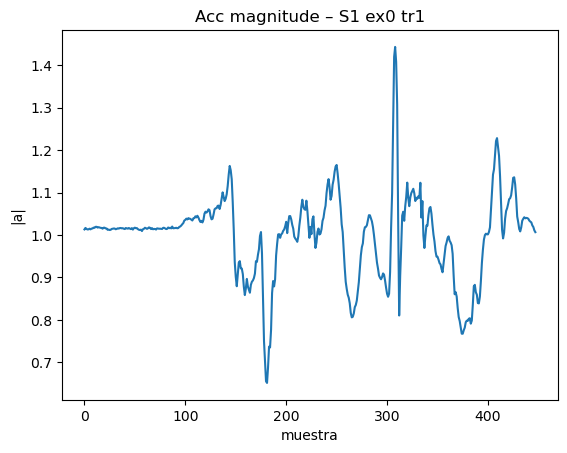

IMU NaNs: False {'min': -240.3282470703125, 'max': 249.12977600097656, 'mean': 0.05301917734171487, 'std': 28.336511829562046}
EMG NaNs: False {'min': -0.3313344014648661, 'max': 0.4382543678950179, 'mean': -0.006929098101245534, 'std': 0.02684509677399891}
len(emg)/len(imu) = 8.5000


In [5]:
row0 = df.dropna(subset=["imu_path", "emg_path"]).iloc[0]

imu = load_TxC(row0.imu_path)  # (T_imu, C_imu)
emg = load_TxC(row0.emg_path)  # (T_emg, C_emg)

print("imu shape:", imu.shape, "| emg shape:", emg.shape)

ax, ay, az = imu[:, 0], imu[:, 1], imu[:, 2]
acc_mag = np.sqrt(ax**2 + ay**2 + az**2)

plt.figure()
plt.plot(acc_mag)
plt.title(f"Acc magnitude – S{row0.subject} ex{row0.exercise_id} tr{row0.trial}")
plt.xlabel("muestra")
plt.ylabel("|a|")
plt.show()

print("IMU NaNs:", has_nans(imu), quick_stats(imu))
print("EMG NaNs:", has_nans(emg), quick_stats(emg))

n_imu = len(imu)
n_emg = len(emg)
len_ratio = n_emg / n_imu
print(f"len(emg)/len(imu) = {len_ratio:.4f}")

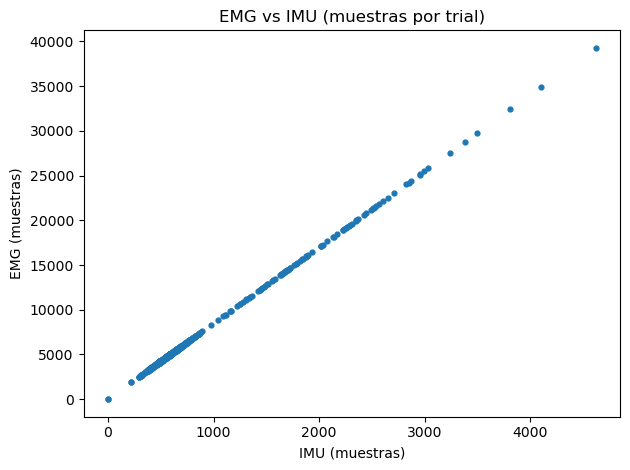

In [6]:
df["imu_len"] = df["imu_shape"].apply(lambda s: s[1] if isinstance(s, tuple) and len(s)>=2 else np.nan)
df["emg_len"] = df["emg_shape"].apply(lambda s: s[1] if isinstance(s, tuple) and len(s)>=2 else np.nan)
df["len_ratio_emg_imu"] = df["emg_len"] / df["imu_len"]


# 4) Scatter EMG vs IMU
plt.figure()
plt.scatter(df["imu_len"], df["emg_len"], s=12)
plt.title("EMG vs IMU (muestras por trial)")
plt.xlabel("IMU (muestras)")
plt.ylabel("EMG (muestras)")
plt.tight_layout()
plt.show()

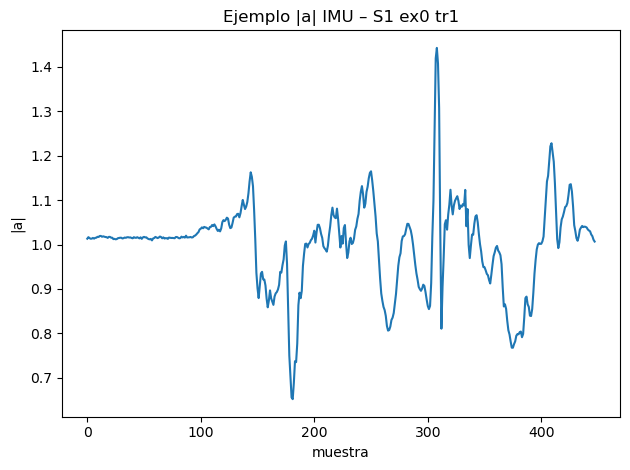

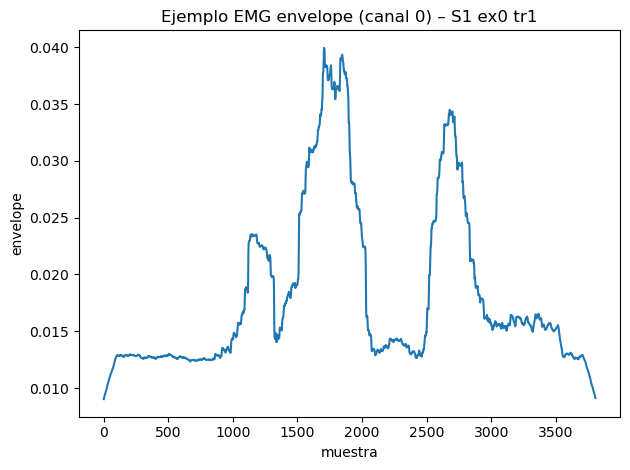

In [13]:
row = df[df.exercise_id==0].iloc[0] if (df.exercise_id==0).any() else df.iloc[0]

acc_mag = np.sqrt(imu[:,0]**2 + imu[:,1]**2 + imu[:,2]**2)
plt.figure()
plt.plot(acc_mag)
plt.title(f"Ejemplo |a| IMU – S{row.subject} ex{row.exercise_id} tr{row.trial}")
plt.xlabel("muestra"); plt.ylabel("|a|"); plt.tight_layout(); plt.show()

env = emg_envelope(emg, win=200)
plt.figure()
plt.plot(env[:,0])
plt.title(f"Ejemplo EMG envelope (canal 0) – S{row.subject} ex{row.exercise_id} tr{row.trial}")
plt.xlabel("muestra"); plt.ylabel("envelope"); plt.tight_layout(); plt.show()

In [14]:
meta_path = Path("metadata.txt")
raw = meta_path.read_text(encoding="utf-8", errors="ignore").splitlines()

data_lines = [ln for ln in raw if re.match(r"^\s*\d+\s", ln)]

rows_meta = []
for ln in data_lines:
    parts = re.split(r"\s{2,}|\t", re.sub(r"\s{2,}", "\t", ln.strip()))
    if len(parts) == 7:          # ✅ SOLO la tabla de pacientes
        rows_meta.append(parts)

meta_df = pd.DataFrame(rows_meta, columns=[
    "ParticipantID", "Gender", "Height_cm", "Weight_kg", "Age_yrs", "Leg", "Pathology"
])

meta_df["ParticipantID"] = pd.to_numeric(meta_df["ParticipantID"], errors="coerce").astype("Int64")
meta_df["Age_yrs"] = pd.to_numeric(meta_df["Age_yrs"], errors="coerce")
meta_df["Height_cm"] = pd.to_numeric(meta_df["Height_cm"], errors="coerce")
meta_df["Weight_kg"] = pd.to_numeric(meta_df["Weight_kg"], errors="coerce")

meta_df = meta_df.dropna(subset=["ParticipantID"]).copy()
meta_df["ParticipantID"] = meta_df["ParticipantID"].astype(int)

meta_df.to_csv("metadata.csv", index=False)
display(meta_df.head())
print("n_subjects meta:", meta_df["ParticipantID"].nunique())

,ParticipantID,Gender,Height_cm,Weight_kg,Age_yrs,Leg,Pathology
0,1,Male,1.82,87,27,left,meniscus
1,2,Male,1.82,118,47,left,meniscus
2,3,Female,1.52,83,56,left,osteoarthritis
3,4,Female,1.60,83,48,right,osteoarthritis
4,5,Male,1.81,85,31,right,tendonitis


n_subjects meta: 31


In [8]:
def compute_imu_features(imu: np.ndarray) -> dict:
    ax, ay, az = imu[:, 0], imu[:, 1], imu[:, 2]
    acc_mag = np.sqrt(ax**2 + ay**2 + az**2)

    feats = {
        "imu_accmag_mean": float(np.mean(acc_mag)),
        "imu_accmag_std": float(np.std(acc_mag)),
        "imu_accmag_max": float(np.max(acc_mag)),
        "imu_accmag_p95": float(np.percentile(acc_mag, 95)),
    }

    if imu.shape[1] >= 6:
        gx, gy, gz = imu[:, 3], imu[:, 4], imu[:, 5]
        gyro_mag = np.sqrt(gx**2 + gy**2 + gz**2)
        feats.update({
            "imu_gyromag_mean": float(np.mean(gyro_mag)),
            "imu_gyromag_std": float(np.std(gyro_mag)),
            "imu_gyromag_max": float(np.max(gyro_mag)),
            "imu_gyromag_p95": float(np.percentile(gyro_mag, 95)),
        })

    return feats

def preprocess_emg(emg: np.ndarray, win: int = 200) -> np.ndarray:
    emg_dc = emg - np.mean(emg, axis=0, keepdims=True)
    env = emg_envelope(emg_dc, win=win)
    return env

def compute_emg_features(emg: np.ndarray, win: int = 200) -> dict:
    env = preprocess_emg(emg, win=win)
    env_ch0 = env[:, 0]
    env_global = np.mean(env, axis=1)

    feats = {
        "emg_ch0_env_mean": float(np.mean(env_ch0)),
        "emg_ch0_env_std": float(np.std(env_ch0)),
        "emg_ch0_env_max": float(np.max(env_ch0)),
        "emg_ch0_env_p95": float(np.percentile(env_ch0, 95)),

        "emg_global_env_mean": float(np.mean(env_global)),
        "emg_global_env_std": float(np.std(env_global)),
        "emg_global_env_max": float(np.max(env_global)),
        "emg_global_env_p95": float(np.percentile(env_global, 95)),
    }
    return feats

def extract_features_for_row(row) -> dict | None:
    try:
        imu = load_TxC(row.imu_path)
        emg = load_TxC(row.emg_path)

        imu_feats = compute_imu_features(imu)
        emg_feats = compute_emg_features(emg, win=200)

        feats = {
            "subject": row.subject,
            "exercise_id": row.exercise_id,
            "trial": row.trial,
            "imu_len": int(len(imu)),
            "emg_len": int(len(emg)),
            "len_ratio_emg_imu": float(len(emg) / len(imu)),
        }
        feats.update(imu_feats)
        feats.update(emg_feats)
        return feats
    except Exception:
        return None

In [9]:
df_valid = df[(df["imu_exists"]) & (df["emg_exists"])].copy()

feature_rows = []
for _, r in df_valid.iterrows():
    feats = extract_features_for_row(r)
    if feats is not None:
        feature_rows.append(feats)

features_df = pd.DataFrame(feature_rows)
print(features_df.shape)
display(features_df.head())

(2084, 22)


,subject,exercise_id,trial,imu_len,emg_len,len_ratio_emg_imu,imu_accmag_mean,imu_accmag_std,imu_accmag_max,imu_accmag_p95,...,imu_gyromag_max,imu_gyromag_p95,emg_ch0_env_mean,emg_ch0_env_std,emg_ch0_env_max,emg_ch0_env_p95,emg_global_env_mean,emg_global_env_std,emg_global_env_max,emg_global_env_p95
0,1,0,1,448,3808,8.5,0.999222,0.098902,1.442623,1.131357,...,166.830407,159.905001,0.011200,0.010289,0.037874,0.033728,0.012837,0.009930,0.041420,0.033819
1,1,0,2,496,4216,8.5,1.002206,0.103702,1.338406,1.146115,...,234.507940,139.115841,0.009190,0.007733,0.032042,0.024040,0.012490,0.011031,0.048033,0.036518
2,1,0,3,468,3978,8.5,1.000151,0.080868,1.268263,1.105984,...,170.564664,150.306468,0.010828,0.009748,0.036509,0.031314,0.013111,0.010204,0.037347,0.030871
3,1,0,4,476,4046,8.5,1.003110,0.094185,1.230914,1.118336,...,216.115219,147.677125,0.010438,0.010127,0.043413,0.034380,0.014028,0.011856,0.046266,0.036993
4,1,0,5,484,4114,8.5,1.003883,0.086680,1.233887,1.101139,...,207.762999,141.153516,0.009087,0.008685,0.035427,0.027361,0.011306,0.008768,0.031054,0.028314


In [10]:
def exercise_type(ex_id):
    if ex_id in [0, 1, 2]:
        return "squat"
    if ex_id in [3, 4, 5]:
        return "sle"
    if ex_id in [6, 7, 8]:
        return "walking"
    return "unknown"

features_df["exercise_type"] = features_df["exercise_id"].apply(exercise_type)

# Etiqueta binaria: correct vs wrong (según tu mapping)
correct_ids = [0, 3, 6]
features_df["is_correct"] = features_df["exercise_id"].isin(correct_ids).astype(int)

features_df[["subject", "exercise_id", "exercise_type", "is_correct"]].head()

,subject,exercise_id,exercise_type,is_correct
0,1,0,squat,1
1,1,0,squat,1
2,1,0,squat,1
3,1,0,squat,1
4,1,0,squat,1


In [11]:
pd.crosstab(features_df["subject"], features_df["exercise_type"])

exercise_type,sle,squat,walking
subject,,,
1,32,17,4
2,33,20,1
3,33,33,5
4,34,40,2
5,30,39,3
6,35,35,4
7,33,28,3
8,33,37,5
9,33,43,3


In [12]:
forbidden_cols = [
    "exercise_id",          # si el target es is_correct, no queremos que el modelo “adivine” por tipo
    "trial",
    "imu_len",
    "emg_len",
    "len_ratio_emg_imu",
]

# Este df ya queda listo para tu cuaderno 2/3 (EDA + training)
features_model_df = features_df.drop(columns=forbidden_cols, errors="ignore").copy()

print("Columnas finales para modelado:")
print(features_model_df.columns.tolist())

# Guardados
features_df.to_csv("features_with_meta_and_target.csv", index=False)         # completo (con exercise_id, etc.)
features_model_df.to_csv("features_model_ready.csv", index=False)            # limpio para ML

Columnas finales para modelado:
['subject', 'imu_accmag_mean', 'imu_accmag_std', 'imu_accmag_max', 'imu_accmag_p95', 'imu_gyromag_mean', 'imu_gyromag_std', 'imu_gyromag_max', 'imu_gyromag_p95', 'emg_ch0_env_mean', 'emg_ch0_env_std', 'emg_ch0_env_max', 'emg_ch0_env_p95', 'emg_global_env_mean', 'emg_global_env_std', 'emg_global_env_max', 'emg_global_env_p95', 'exercise_type', 'is_correct']
